In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62785 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:62788" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:62813, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:62807, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:62810, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
#Let's try an out of the box Logisitic Regression
logi = LogisticRegression(verbose=True)
with joblib.parallel_backend('dask'):
    logi.fit(train_X, np.ravel(train_y))
logi.score(test_X, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.4s finished


0.7520538720538721

Not terrible. We can make some adjustments to the hyperparameters to see if they increases our accuracy. We'll save the score and parameters for review.

In [7]:
#Create dataframe to store metrics and parameters
logi_deets = pd.DataFrame(logi.get_params(), index=['LR_OBO'])
logi_deets.insert(0, value=logi.score(test_X, test_y), column='Accuracy')
logi_deets

,Accuracy,C,class_weight,dual,fit_intercept,intercept_scaling,l1_ratio,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start
LR_OBO,0.752054,1.0,None,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False


In [8]:
#First let's see if we do better with balanced class weights
logi_2 = LogisticRegression(class_weight='balanced', verbose=True)
with joblib.parallel_backend('dask'):
    logi_2.fit(train_X, np.ravel(train_y))
logi_2.score(test_X, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.2s finished


0.657979797979798

In [9]:
#store metrics and parameters
a = logi_2.get_params()
a['Accuracy'] = logi_2.score(test_X, test_y)
logi_deets = pd.concat([logi_deets, pd.DataFrame(a, index=['LR_BAL'])], axis=0, join='outer')
logi_deets

,Accuracy,C,class_weight,dual,fit_intercept,intercept_scaling,l1_ratio,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start
LR_OBO,0.752054,1.0,None,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False
LR_BAL,0.657980,1.0,balanced,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False


Using class weights does not improve the accuracy, in fact it decreases it. Let's try each of the penalty options for improvement and some different values for C for each. We will need to use the liblinear solver to access the L1 penalty option.

In [10]:
#Run through for loop for hyperparamter tuning of C and penalty
C = [0.1, 0.5, 1, 5, 10]
penalty = ['l1', 'l2']
count=1
for p in penalty:
    for c in C:
        logi_pen = LogisticRegression(solver='liblinear', C=c, penalty=p, verbose=True)
        logi_pen.fit(train_X, np.ravel(train_y))
        deets = logi_pen.get_params()
        deets['Accuracy']=logi_pen.score(test_X, test_y)
        logi_deets = pd.concat([logi_deets, pd.DataFrame(deets, index=['LR_PEN{}'.format(count)])], axis=0, join='outer')
        count+=1


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [11]:
logi_deets

,Accuracy,C,class_weight,dual,fit_intercept,intercept_scaling,l1_ratio,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start
LR_OBO,0.752054,1.0,None,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False
LR_BAL,0.657980,1.0,balanced,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False
LR_PEN1,0.749428,0.1,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN2,0.752997,0.5,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN3,0.752727,1.0,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN4,0.753535,5.0,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN5,0.753333,10.0,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN6,0.753199,0.1,None,False,True,1,None,100,auto,None,l2,None,liblinear,0.0001,True,False
LR_PEN7,0.753199,0.5,None,False,True,1,None,100,auto,None,l2,None,liblinear,0.0001,True,False
LR_PEN8,0.752121,1.0,None,False,True,1,None,100,auto,None,l2,None,liblinear,0.0001,True,False


The adjustments to the penalty and regularization strength show that, though slight, a higher regularization strength increases the accuracy and that the L2 penalty also perfomrs better than L1.

As a final check we will increase the number of iterations the model is allowed to run through for minimzation and run through a cross validation check to make sure we are still abel to generalize well. 

In [12]:
#Run model with more iterations to see if we can improve accuracy
logi_iter = LogisticRegression(penalty='l2', C=10, max_iter=250, verbose=True, solver='liblinear')
logi_iter.fit(train_X, np.ravel(train_y))
logi_iter.score(test_X, test_y)

[LibLinear]

0.7534680134680135

No great improvement, we will stick with the default 100 iterations max.

In [13]:
a = logi_iter.get_params()
a['Accuracy'] = logi_iter.score(test_X, test_y)
logi_deets = pd.concat([logi_deets, pd.DataFrame(a, index=['LR_ITER_250'])], axis=0, join='outer')
logi_deets

,Accuracy,C,class_weight,dual,fit_intercept,intercept_scaling,l1_ratio,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start
LR_OBO,0.752054,1.0,None,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False
LR_BAL,0.657980,1.0,balanced,False,True,1,None,100,auto,None,l2,None,lbfgs,0.0001,True,False
LR_PEN1,0.749428,0.1,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN2,0.752997,0.5,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN3,0.752727,1.0,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN4,0.753535,5.0,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN5,0.753333,10.0,None,False,True,1,None,100,auto,None,l1,None,liblinear,0.0001,True,False
LR_PEN6,0.753199,0.1,None,False,True,1,None,100,auto,None,l2,None,liblinear,0.0001,True,False
LR_PEN7,0.753199,0.5,None,False,True,1,None,100,auto,None,l2,None,liblinear,0.0001,True,False
LR_PEN8,0.752121,1.0,None,False,True,1,None,100,auto,None,l2,None,liblinear,0.0001,True,False


In [14]:
#Re-run best model
logi_f = LogisticRegression(penalty='l2', C=10, verbose=True, solver='liblinear')
logi_f.fit(train_X, np.ravel(train_y))
logi_f.score(test_X, test_y)

[LibLinear]

0.7534680134680135

In [15]:
#Confirm generalizability via 5-fold cross validation
print(cross_val_score(logi_f, train_X, train_y, cv=5))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][0.75544332 0.75521886 0.75140292 0.75611672 0.74994388]


Cross Validation shows a pretty consistent result. We can be confident that this model will generally relativeley well. Let's take a look at a Confusion matrix to see which classes our best Logistic Regression model is doing best with.

<Figure size 2880x576 with 0 Axes>

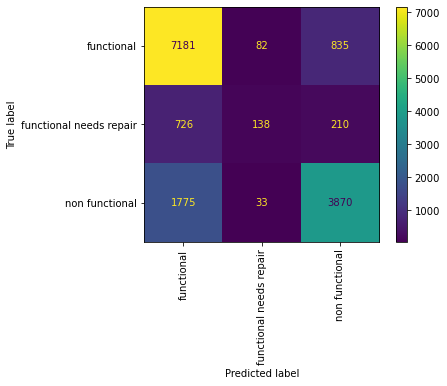

                         precision    recall  f1-score   support

             functional       0.74      0.89      0.81      8098
functional needs repair       0.55      0.13      0.21      1074
         non functional       0.79      0.68      0.73      5678

               accuracy                           0.75     14850
              macro avg       0.69      0.57      0.58     14850
           weighted avg       0.74      0.75      0.73     14850



In [16]:
#Visual class metrics using confusion matrix and classification report
y_pred = logi_f.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=logi_f.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=logi_f.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=logi_f.classes_))

We can see that the model performed best on the functional label with non functional just behind it and functional needs repair well below the other two. This makes sense as there are many less cases of functional needs repair so the model doesn't have as much data to learn from.

In [17]:
#output for comparision
logi_deets.to_pickle('Data/scores/LR.pkl')